In [10]:
from models import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
#     'chen',
    'chua',
    # 'switch'
]
names = [n + '1d' for n in names]

n_dim = 1
horizon = 1
N = 10000
N_h = 200
n_history = 20
num_prepare = 1000
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity= connectivity,
    nz= nz,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1,
    activation = np.tanh
)

path = 'result/how skip-con affect performance'
if not os.path.exists(path):
    os.makedirs(path)

    
def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        _, model_type, kwargs = conf
        model = model_type(**kwargs)
        model.train(x_train, y_train, num_prepare=num_prepare)
        Predictions = model.predict(x_test, num_prepare=num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
for file in range(1):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma', 'skip_con','encoder_type','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('第{}轮'.format(file))
    for system_name in names:
        '''
        数据集
        '''
        x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
        x += np.random.randn(*x.shape)*0.001

        x_train = np.vstack([select_samples(x, train_start + i, num_train+num_prepare) for i in range(n_history)])
        y_train = select_samples(x, train_start+num_prepare + n_history + horizon - 1, num_train)
        x_test = np.vstack([select_samples(x, test_start + i, num_test+num_prepare) for i in range(n_history)])
        y_test = select_samples(x, test_start+num_prepare + n_history + horizon - 1, num_test) 
       
        for skip_con in range(n_history):
            rc = reservoirConf

            '''
            单步预测
            '''
            model_confs = []
#             model_confs += [('ESN', 
#                              ESN, 
#                              dict(reservoirConf=rc,encoder='transform', skip_con = skip_con))]
            
#             model_confs += [('ESN-1000', 
#                              ESN, 
#                              dict(reservoirConf=rc,encoder='echostate', skip_con = skip_con))]
            model_confs.append(
                [('RBFLN-RE-transform', 
                RBFN_RE, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform',skip_con=skip_con)) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
            model_confs.append(
                [('ESN-ATTN-transform',
                ESN_ATTN, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform',skip_con=skip_con))
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )


            model_names = [conf[0] for conf in model_confs]

            colors = list(cnames.keys())

            Predictions = [np.empty((n_dim, num_test)) for _ in range(len(model_confs))]
            MSE = [0.0] * len(model_confs)

            for j, conf in enumerate(model_confs):
                conf = select_model(conf)
                model_name, model_type, kwargs = conf

                model = model_type(**kwargs)

                model.train(x_train, y_train, num_prepare=num_prepare)

                Predictions[j] = model.predict(x_test, num_prepare=num_prepare)

                MSE[j] = mse(Predictions[j], y_test)

                result.loc[result.shape[0]] = {
                    'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    'system_name'       : system_name,
                    'n_dim'             : n_dim,
                    'n_history'         : n_history,
                    'horizon'           : horizon,
                    'model_name'        : model_name,
                    'N_h'               : N_h,
                    'sigma'             : kwargs.get('sigma', 0),
                    'skip_con'          : skip_con,
                    'nz'                : nz,
                    'connectivity'      : connectivity,
                    'encoder_type'      : kwargs.get('encoder', None),
                    'mse'               : MSE[j]
                }
#                 print(result.loc[result.shape[0]-1])



    result.to_csv(result_file, index=False)
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

第0轮
数据处理用了0年0月0日7小时46分钟6秒


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



system_names = ['rossler','rabinovich_fabrikant','lorentz','chua']
system_names = [system + '1d' for system in system_names]



result_file0 = path + '/result_0.csv' 
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)
set(df['model_name'])
df

,system_name,n_dim,n_history,horizon,model_name,N_h,sigma,skip_con,encoder_type,nz,connectivity,mse
datetime,,,,,,,,,,,,
2020-08-10 21:46:18,rossler1d,1,20,1,ESN,200,0.000,0,transform,100,1,0.000005
2020-08-10 21:46:18,rossler1d,1,20,1,ESN-1000,200,0.000,0,echostate,100,1,0.000004
2020-08-10 21:46:19,rossler1d,1,20,1,ESN,200,0.000,1,transform,100,1,0.000004
2020-08-10 21:46:19,rossler1d,1,20,1,ESN-1000,200,0.000,1,echostate,100,1,0.000005
2020-08-10 21:46:19,rossler1d,1,20,1,ESN,200,0.000,2,transform,100,1,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-11 07:14:26,chua1d,1,20,1,ESN-ATTN-transform,200,2.000,17,transform,100,1,0.000019
2020-08-11 07:14:40,chua1d,1,20,1,RBFLN-RE-transform,200,1.000,18,transform,100,1,0.000005
2020-08-11 07:14:55,chua1d,1,20,1,ESN-ATTN-transform,200,0.125,18,transform,100,1,0.000018


rossler1d


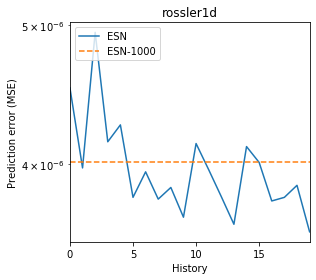

rabinovich_fabrikant1d


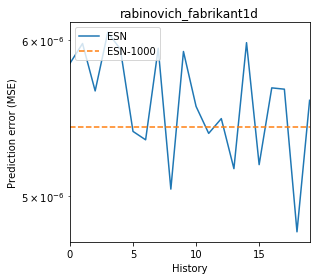

lorentz1d


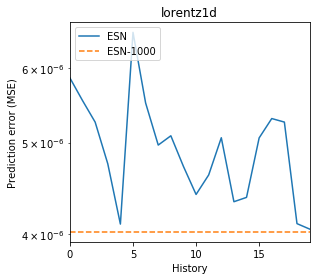

chua1d


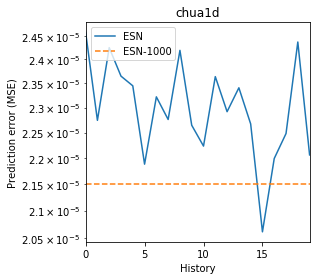

In [12]:
for system_name in system_names:
    print(system_name)

    model_names = ['ESN', 'ESN-1000']

    average = pd.DataFrame()
    for i in range(1):
        result_file = path + '/result_' +str(i) + '.csv' 
        df = pd.read_csv(result_file, index_col = 'datetime')
        df.index = pd.DatetimeIndex(df.index)

        result = df[df['system_name'].isin([system_name]) & 
                    df['model_name'].isin(model_names)]


        final = None
        for w in set(result['skip_con']):

            temp = result.loc[result['skip_con'] == w, ['model_name', 'mse', 'skip_con']].groupby('model_name').min().reset_index()

            final = temp if final is None else final.append(temp, ignore_index=True)

        average = average.append(final,ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(4.5,4))
    models1 = ['ESN',]
    models2 = ['ESN-1000']
    
    for name in models1:
        average.loc[average['model_name'] == name].groupby('skip_con').mean().sort_values(by='skip_con').plot(ax = ax)

    for name in models2:
        esn = average.loc[average['model_name'] == name].groupby('skip_con').mean().mean()
        plt.plot([0,200], [esn,esn], '--', label=name)
    
    plt.legend(labels= models1+models2, loc='upper left')
    ax.set_yscale("log")
#     ax.set_xscale("log")
    plt.xlabel('History')
    plt.ylabel('Prediction error (MSE)')
#     plt.xticks([5,10,15])
    plt.title(system_name)
    plt.tight_layout()

    plt.savefig(path+'/'+system_name+'_skip.jpg')
    plt.show()